# Model training

In this notebook, we will train our first model and apply this model to a soundscape. We will keep the amount of training samples, species and soundscapes to a minimum to keep the execution time as short as possible. Remember, this is only a sample implementation, feel free to explore your own workflow.

These are the steps that we will cover:


* select audio files we want to use for training  
* extract spectrograms from those files and save them in a working directory  
* load selected samples into a large in-memory dataset  
* build a simple beginners CNN  
* train the model  
* apply the model to a selected soundscape and look at the results 

# 1. Settings and imports

Let’s begin with imports and a few basic settings.

In [4]:
import os

import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import librosa
import numpy as np

from sklearn.utils import shuffle
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf

# Global vars
RANDOM_SEED = 1337
SAMPLE_RATE = 32000
SIGNAL_LENGTH = 5.0 # 5 seconds
SPEC_LENGTH = 5.0 # 5 seconds
SPEC_SHAPE = (48, 128) # height x width
# SPEC_SHAPE = (257, 384) # height x width
FMIN = 500
FMAX = 12500
MAX_AUDIO_FILES = 3000

# 2. Data preparation

The training data for this competition contains tens of thousands of audio files for 397 species. That’s way too much for this tutorial, so we will limit our species selection to species that have at least 200 recordings with a rating of 4 or better.

In [5]:
# Code adapted from: 
# https://www.kaggle.com/frlemarchand/bird-song-classification-using-an-efficientnet
# Make sure to check out the entire notebook.

# Load metadata file
train = pd.read_csv('../input/birdclef-2021/train_metadata.csv',)

# Limit the number of training samples and classes
# First, only use high quality samples
train = train.query('rating>=4')

# Second, assume that birds with the most training samples are also the most common
# A species needs at least 200 recordings with a rating above 4 to be considered common
birds_count = {}
for bird_species, count in zip(train.primary_label.unique(), 
                               train.groupby('primary_label')['primary_label'].count().values):
    birds_count[bird_species] = count
most_represented_birds = [key for key,value in birds_count.items() if value >= 300] 

TRAIN = train.query('primary_label in @most_represented_birds')
LABELS = sorted(TRAIN.primary_label.unique())

# Let's see how many species and samples we have left
print('NUMBER OF SPECIES IN TRAIN DATA:', len(LABELS))
print('NUMBER OF SAMPLES IN TRAIN DATA:', len(TRAIN))
print('LABELS:', most_represented_birds)

NUMBER OF SPECIES IN TRAIN DATA: 11
NUMBER OF SAMPLES IN TRAIN DATA: 4701
LABELS: ['barswa', 'comrav', 'eursta', 'gbwwre1', 'houspa', 'houwre', 'norcar', 'redcro', 'rewbla', 'sonspa', 'spotow']


Ok, that leaves us with 27 species and 8,548 audio files. The species list includes very common species like the House Sparrow (houspa), Blue Jay (blujay), or Song Sparrow (sonspa). This is not a bad selection to start experimenting.

# 3. Extract training samples

We need to define a function that extracts spectrograms for a given audio file. This function needs to load a file with Librosa (we only use the first 15 seconds in this tutorial), extract mel spectrograms and save each spectrogram as PNG image in a working directory for later access.

In [6]:
import soundfile as sf
# Shuffle the training data and limit the number of audio files to MAX_AUDIO_FILES
TRAIN = shuffle(TRAIN, random_state=RANDOM_SEED)[:MAX_AUDIO_FILES]

# Define a function that splits an audio file, 
# extracts spectrograms and saves them in a working directory
def get_spectrograms(filepath, primary_label, output_dir):
    
    # Open the file with librosa (limited to the first 15 seconds)
    sig, rate = librosa.load(filepath, sr=SAMPLE_RATE, offset=None, duration=15)
    
    # Split signal into five second chunks
    sig_splits = []
    for i in range(0, len(sig), int(SIGNAL_LENGTH * SAMPLE_RATE)):
        split = sig[i:i + int(SIGNAL_LENGTH * SAMPLE_RATE)]

        # End of signal?
        if len(split) < int(SIGNAL_LENGTH * SAMPLE_RATE):
            break
        
        sig_splits.append(split)
        
    # Extract mel spectrograms for each audio chunk
    s_cnt = 0
    saved_samples = []
    for chunk in sig_splits:
        
        hop_length = int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))
        mel_spec = librosa.feature.melspectrogram(y=chunk, 
                                                  sr=SAMPLE_RATE, 
                                                  n_fft=1024, 
                                                  hop_length=hop_length, 
                                                  n_mels=SPEC_SHAPE[0], 
                                                  fmin=FMIN, 
                                                  fmax=FMAX)
    
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max) 
        
        # Normalize
        mel_spec -= mel_spec.min()
        mel_spec /= mel_spec.max()

        # Save as image file
        save_dir = os.path.join(output_dir, primary_label)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, filepath.rsplit(os.sep, 1)[-1].rsplit('.', 1)[0] + 
                                 '_' + str(s_cnt) + '.png')
        
#         # save chunck soundfile
#         sf.write(save_path, chunk, SAMPLE_RATE, format='ogg', subtype='vorbis')
        
        im = Image.fromarray(mel_spec * 255.0).convert("L")
        im.save(save_path)
        
        saved_samples.append(save_path)
        s_cnt += 1
        
    return saved_samples

print('FINAL NUMBER OF AUDIO FILES IN TRAINING DATA:', len(TRAIN))

FINAL NUMBER OF AUDIO FILES IN TRAINING DATA: 3000


Ok, we have 1,500 audio files that cover 27 species, let's extract spectrograms (this might take a while).

In [7]:
# Parse audio files and extract training samples
input_dir = '../input/birdclef-2021/train_short_audio/'
output_dir = '../working/melspectrogram_dataset/'
samples = []
with tqdm(total=len(TRAIN)) as pbar:
    for idx, row in TRAIN.iterrows():
        pbar.update(1)
        
        if row.primary_label in most_represented_birds:
            audio_file_path = os.path.join(input_dir, row.primary_label, row.filename)
            samples += get_spectrograms(audio_file_path, row.primary_label, output_dir)
            
TRAIN_SPECS = shuffle(samples, random_state=RANDOM_SEED)
print('SUCCESSFULLY EXTRACTED {} SPECTROGRAMS'.format(len(TRAIN_SPECS)))

100%|██████████| 3000/3000 [04:13<00:00, 11.82it/s]

SUCCESSFULLY EXTRACTED 8312 SPECTROGRAMS


Alright, we got 4,157 training spectrograms. That's roughly 150 for each species which is not too bad.

Let's make sure the spectrograms look right and show the first 12.

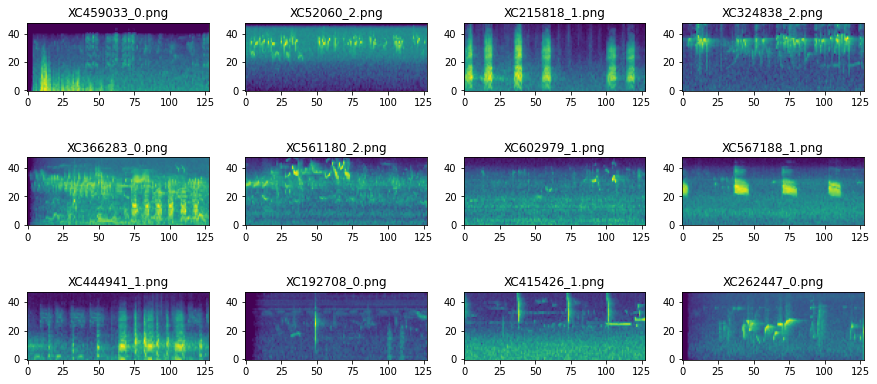

In [8]:
# Plot the first 12 spectrograms of TRAIN_SPECS
plt.figure(figsize=(15, 7))
for i in range(12):
    spec = Image.open(TRAIN_SPECS[i])
    plt.subplot(3, 4, i + 1)
    plt.title(TRAIN_SPECS[i].split(os.sep)[-1])
    plt.imshow(spec, origin='lower')

Nice! These are good samples. Notice how some of them only contain a fraction of a bird call? That's an issue we won't deal with in this tutorial. We will simply ignore the fact that samples might not contain any bird sounds.

# 4. Load training samples

For now, our spectrograms reside in a working directory. If we want to train a model, we have to load them into memory. Yet, with potentially hundreds of thousands of extracted spectrograms, an in-memory dataset is not a good idea. But for now, loading samples from disk and combining them into a large NumPy array is fine. It’s the easiest way to use these data for training with Keras.

In [9]:
# Parse all samples and add spectrograms into train data, primary_labels into label data
train_specs, train_labels = [], []
with tqdm(total=len(TRAIN_SPECS)) as pbar:
    for path in TRAIN_SPECS:
        pbar.update(1)

        # Open image
        spec = Image.open(path)

        # Convert to numpy array
        spec = np.array(spec, dtype='float32')
        
        # Normalize between 0.0 and 1.0
        # and exclude samples with nan 
        spec -= spec.min()
        spec /= spec.max()
        if not spec.max() == 1.0 or not spec.min() == 0.0:
            continue

        # Add channel axis to 2D array
        spec = np.expand_dims(spec, -1)

        # Add new dimension for batch size
        spec = np.expand_dims(spec, 0)
        
#         # Open the file with librosa (limited to the first 15 seconds)
#         spec, rate = librosa.load(path, sr=SAMPLE_RATE, offset=None)

        # Add to train data
        if len(train_specs) == 0:
            train_specs = spec
        else:
            train_specs = np.vstack((train_specs, spec))

        # Add to label data
        target = np.zeros((len(LABELS)), dtype='float32')
        bird = path.split(os.sep)[-2]
        target[LABELS.index(bird)] = 1.0
        if len(train_labels) == 0:
            train_labels = target
        else:
            train_labels = np.vstack((train_labels, target))

100%|██████████| 8312/8312 [06:34<00:00, 21.09it/s] 


# 5. Build a simple model

Alright, our dataset is ready, now we need to define a model architecture. In this tutorial, we’ll use a very simplistic, AlexNet-like design with four convolutional layers and three dense layers. It might make sense to choose an off-the-shelve TF model that was pre-trained on audio data, but we would need to adjust the inputs (i.e., the resolution of our spectrograms) to fit the external model. So we keep it simple and build our own model.

In [ ]:
from tensorflow.keras import datasets, layers, models, losses, Model

# Resnet50 Model
base_model = tf.keras.applications.ResNet50V2(
    include_top=False, weights=None, input_shape=(48, 128, 3))

for layer in base_model.layers:
    layer.trainable = True

x = layers.Flatten()(base_model.output)
x = layers.Dense(27, activation='relu')(x)
predictions = layers.Dense(27, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)

In [10]:
# Make sure your experiments are reproducible
tf.random.set_seed(RANDOM_SEED)

# Build a simple model as a sequence of  convolutional blocks.
# Each block has the sequence CONV --> RELU --> BNORM --> MAXPOOL.
# Finally, perform global average pooling and add 2 dense layers.
# The last layer is our classification layer and is softmax activated.
# (Well it's a multi-label task so sigmoid might actually be a better choice)
model = tf.keras.Sequential([
    
    # First conv block
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', 
                           input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Second conv block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Third conv block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Fourth conv block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Global pooling instead of flatten()
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    # Dense block
    tf.keras.layers.Dense(256, activation='relu'),   
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(256, activation='relu'),   
    tf.keras.layers.Dropout(0.5),
    
    # Classification layer
    tf.keras.layers.Dense(len(LABELS), activation='softmax')
])
print('MODEL HAS {} PARAMETERS.'.format(model.count_params()))

MODEL HAS 199755 PARAMETERS.


This is not a huge CNN, it only has ~200,000 parameters. Yet, we also only have a very small dataset with just 27 classes.

Next, we need to specify an optimzer, initial learning rate, a loss function and a metric.

In [11]:
# Compile the model and specify optimizer, loss and metric
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy'])

Callbacks make our life easier, the three that we're adding will take care of saving the best checkpoint, they will reduce the learning rate whenever the training process stalls, and they will stop the training if the model is overfitting.

In [12]:
# Add callbacks to reduce the learning rate if needed, early stopping, and checkpoint saving
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                  patience=2, 
                                                  verbose=1, 
                                                  factor=0.5),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              verbose=1,
                                              patience=5),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', 
                                                monitor='val_loss',
                                                verbose=0,
                                                save_best_only=True)]

Here we go, everything is in place, let's train a model. We'll use 20% of our training data for validation and we'll stop after 25 epochs.

In [13]:
# Let's train the model for a few epochs
H = model.fit(train_specs, 
          train_labels,
          batch_size=32,
          validation_split=0.2,
          callbacks=callbacks,
          epochs=50)

Epoch 1/50
208/208 [==============================] - 29s 135ms/step - loss: 2.3473 - accuracy: 0.2130 - val_loss: 3.0373 - val_accuracy: 0.1058
Epoch 2/50
208/208 [==============================] - 27s 131ms/step - loss: 1.6760 - accuracy: 0.4440 - val_loss: 2.4157 - val_accuracy: 0.1972
Epoch 3/50
208/208 [==============================] - 27s 130ms/step - loss: 1.4106 - accuracy: 0.5478 - val_loss: 1.4892 - val_accuracy: 0.5280
Epoch 4/50
208/208 [==============================] - 27s 130ms/step - loss: 1.2401 - accuracy: 0.6186 - val_loss: 1.6281 - val_accuracy: 0.5087
Epoch 5/50
208/208 [==============================] - 27s 129ms/step - loss: 1.1109 - accuracy: 0.6635 - val_loss: 1.4160 - val_accuracy: 0.5833
Epoch 6/50
208/208 [==============================] - 27s 130ms/step - loss: 0.9734 - accuracy: 0.7037 - val_loss: 1.0546 - val_accuracy: 0.6861
Epoch 7/50
208/208 [==============================] - 27s 131ms/step - loss: 0.8587 - accuracy: 0.7455 - val_loss: 1.0046 - val_ac

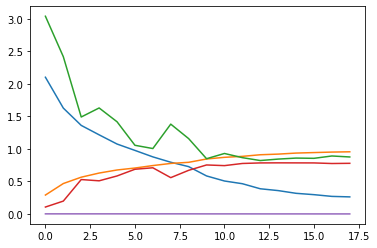

In [14]:
history = pd.DataFrame(H.history)
plt.figure()
plt.plot(history)

Not too bad, we got into the 60s of our validation accuracy. But remember, we're training on focal recordings and validate on focal recordings. The scores might not tell us much about how well we will perform on soundscape data.

We'll have to check ourselves, luckily, we have some validation soundscapes.

# 6. Soundscape analysis

In this tutorial, we will simply pick a soundscape from the training data, but the overall process can easily be automated and then applied to all soundscape files. And again, we have to load a file with Librosa, extract spectrograms for 5-second chunks, pass each chunk through the model and eventually assign a label to the 5-second audio chunk.

Let's use a soundscape that actually contains some of the species that we trained our model for. The file "28933_SSW_20170408.ogg" seems to contain a lot of Song Sparrow (sonspa) vocalizations, let's try this one then.

In [15]:
# Load the best checkpoint
model = tf.keras.models.load_model('./best_model.h5')

# Pick a soundscape
soundscape_path = '../input/birdclef-2021/train_soundscapes/28933_SSW_20170408.ogg'

# Open it with librosa
sig, rate = librosa.load(soundscape_path, sr=SAMPLE_RATE)

# Store results so that we can analyze them later
data = {'row_id': [], 'prediction': [], 'score': []}

# Split signal into 5-second chunks
# Just like we did before (well, this could actually be a seperate function)
sig_splits = []
for i in range(0, len(sig), int(SIGNAL_LENGTH * SAMPLE_RATE)):
    split = sig[i:i + int(SIGNAL_LENGTH * SAMPLE_RATE)]

    # End of signal?
    if len(split) < int(SIGNAL_LENGTH * SAMPLE_RATE):
        break

    sig_splits.append(split)
    
# Get the spectrograms and run inference on each of them
# This should be the exact same process as we used to
# generate training samples!
seconds, scnt = 0, 0
for chunk in sig_splits:
    
    # Keep track of the end time of each chunk
    seconds += 3
        
    # Get the spectrogram
    hop_length = int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))
    mel_spec = librosa.feature.melspectrogram(y=chunk, 
                                              sr=SAMPLE_RATE, 
                                              n_fft=1024, 
                                              hop_length=hop_length, 
                                              n_mels=SPEC_SHAPE[0], 
                                              fmin=FMIN, 
                                              fmax=FMAX)

    mel_spec = librosa.power_to_db(mel_spec, ref=np.max) 

    # Normalize to match the value range we used during training.
    # That's something you should always double check!
    mel_spec -= mel_spec.min()
    mel_spec /= mel_spec.max()
    
    # Add channel axis to 2D array
    mel_spec = np.expand_dims(mel_spec, -1)

    # Add new dimension for batch size
    mel_spec = np.expand_dims(mel_spec, 0)
    
    # Predict
    p = model.predict(mel_spec)[0]
    
    # Get highest scoring species
    idx = p.argmax()
    species = LABELS[idx]
    score = p[idx]
    
    # Prepare submission entry
    data['row_id'].append(soundscape_path.split(os.sep)[-1].rsplit('_', 1)[0] + 
                          '_' + str(seconds))    
    
    # Decide if it's a "nocall" or a species by applying a threshold
    if score > 0.25:
        data['prediction'].append(species)
        scnt += 1
    else:
        data['prediction'].append('nocall')
        
    # Add the confidence score as well
    data['score'].append(score)
        
print('SOUNSCAPE ANALYSIS DONE. FOUND {} BIRDS.'.format(scnt))

SOUNSCAPE ANALYSIS DONE. FOUND 119 BIRDS.


Ok, we found a few bird species with a score above the threshold. Let's look at the results and see how well we're actually doing.

In [16]:
# Make a new data frame
results = pd.DataFrame(data, columns = ['row_id', 'prediction', 'score'])

# Merge with ground truth so we can inspect
gt = pd.read_csv('../input/birdclef-2021/train_soundscape_labels.csv',)
results = pd.merge(gt, results, on='row_id')

# Let's look at the first 50 entries
results.head(114)

,row_id,site,audio_id,seconds,birds,prediction,score
0,28933_SSW_15,SSW,28933,15,sonspa,sonspa,0.746749
1,28933_SSW_30,SSW,28933,30,sonspa,sonspa,0.611354
2,28933_SSW_45,SSW,28933,45,sonspa,sonspa,0.869811
3,28933_SSW_60,SSW,28933,60,sonspa,redcro,0.546784
4,28933_SSW_75,SSW,28933,75,sonspa,sonspa,0.899840
5,28933_SSW_90,SSW,28933,90,sonspa,sonspa,0.999087
6,28933_SSW_105,SSW,28933,105,sonspa,redcro,0.777461
7,28933_SSW_120,SSW,28933,120,sonspa,sonspa,0.820651
8,28933_SSW_135,SSW,28933,135,sonspa,sonspa,0.312358
9,28933_SSW_150,SSW,28933,150,norcar sonspa,sonspa,0.826385
